*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will create a book recommendation algorithm using **K-Nearest Neighbors**.

You will use the [Book-Crossings dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). This dataset contains 1.1 million ratings (scale of 1-10) of 270,000 books by 90,000 users. 

After importing and cleaning the data, use `NearestNeighbors` from `sklearn.neighbors` to develop a model that shows books that are similar to a given book. The Nearest Neighbors algorithm measures distance to determine the “closeness” of instances.

Create a function named `get_recommends` that takes a book title (from the dataset) as an argument and returns a list of 5 similar books with their distances from the book argument.

This code:

`get_recommends("The Queen of the Damned (Vampire Chronicles (Paperback))")`

should return:

```
[
  'The Queen of the Damned (Vampire Chronicles (Paperback))',
  [
    ['Catch 22', 0.793983519077301], 
    ['The Witching Hour (Lives of the Mayfair Witches)', 0.7448656558990479], 
    ['Interview with the Vampire', 0.7345068454742432],
    ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.5376338362693787],
    ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.5178412199020386]
  ]
]
```

Notice that the data returned from `get_recommends()` is a list. The first element in the list is the book title passed in to the function. The second element in the list is a list of five more lists. Each of the five lists contains a recommended book and the distance from the recommended book to the book passed in to the function.

If you graph the dataset (optional), you will notice that most books are not rated frequently. To ensure statistical significance, remove from the dataset users with less than 200 ratings and books with less than 100 ratings.

The first three cells import libraries you may need and the data to use. The final cell is for testing. Write all your code in between those cells.

In [345]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [346]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2021-07-12 11:20:08--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip.1’

book-crossings.zip. 100%[===================>]  24.88M  10.2MB/s    in 2.4s    

2021-07-12 11:20:11 (10.2 MB/s) - ‘book-crossings.zip.1’ saved [26085508/26085508]

Archive:  book-crossings.zip
replace BX-Book-Ratings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: BX-Book-Ratings.csv     
replace BX-Books.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: BX-Books.csv            
replace BX-Users.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: BX-Users.csv            


In [347]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

In [348]:
# add your code here - consider creating a new cell for each section of code
# Looking at the data
df_books.head()

,isbn,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber


In [349]:
df_ratings.head()

,user,isbn,rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0


In [350]:
df_ratings.tail()

,user,isbn,rating
1149775,276704,1563526298,9.0
1149776,276706,0679447156,0.0
1149777,276709,0515107662,10.0
1149778,276721,0590442449,10.0
1149779,276723,05162443314,8.0


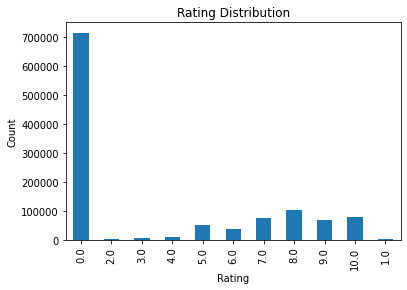

In [351]:
# Plot the daa in ratings to see the distribution of raitings
df_ratings.rating.value_counts(sort = False).plot(kind='bar')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [352]:
df_ratings.shape

(1149780, 3)

In [353]:
# Eliminating the users with less than 200 ratings and books with less than 100 ratings
count_num_users = df_ratings['user'].value_counts()
df_ratings = df_ratings[df_ratings['user'].isin(count_num_users[count_num_users >= 200].index)]
count_num_books = df_ratings['rating'].value_counts()
df_ratings = df_ratings[df_ratings['rating'].isin(count_num_books[count_num_books >= 100].index)]

In [354]:
df_ratings.tail()

,user,isbn,rating
1147612,275970,3829021860,0.0
1147613,275970,4770019572,0.0
1147614,275970,896086097,0.0
1147615,275970,9626340762,8.0
1147616,275970,9626344990,0.0


In [355]:
# Combining a book titles with ratings and users
combined_books_ratings = pd.merge(df_ratings, df_books, on='isbn')
colums_to_drop = ['author']
combined_books_ratings = combined_books_ratings.drop(colums_to_drop, axis = 1)
combined_books_ratings.head()

,user,isbn,rating,title
0,277427,002542730X,10.0,Politically Correct Bedtime Stories: Modern Ta...
1,3363,002542730X,0.0,Politically Correct Bedtime Stories: Modern Ta...
2,11676,002542730X,6.0,Politically Correct Bedtime Stories: Modern Ta...
3,12538,002542730X,10.0,Politically Correct Bedtime Stories: Modern Ta...
4,13552,002542730X,0.0,Politically Correct Bedtime Stories: Modern Ta...


In [356]:
# Trying to sort the books to top rated
combined_books_ratings = combined_books_ratings.dropna(axis = 0, subset = ['title'])

book_ratingCount = (combined_books_ratings.
     groupby(by = ['title'])['rating'].
     count().
     reset_index().
     rename(columns = {'rating': 'totalRatingCount'})
     [['title', 'totalRatingCount']]
    )
book_ratingCount.head()

,title,totalRatingCount
0,A Light in the Storm: The Civil War Diary of ...,2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance ...,1
4,Clifford Visita El Hospital (Clifford El Gran...,1


In [357]:
rating_with_totalRatingCount = combined_books_ratings.merge(book_ratingCount, left_on = 'title', right_on = 'title', how = 'left')
rating_with_totalRatingCount.head()

,user,isbn,rating,title,totalRatingCount
0,277427,002542730X,10.0,Politically Correct Bedtime Stories: Modern Ta...,82
1,3363,002542730X,0.0,Politically Correct Bedtime Stories: Modern Ta...,82
2,11676,002542730X,6.0,Politically Correct Bedtime Stories: Modern Ta...,82
3,12538,002542730X,10.0,Politically Correct Bedtime Stories: Modern Ta...,82
4,13552,002542730X,0.0,Politically Correct Bedtime Stories: Modern Ta...,82


In [358]:
popularity_threshold = 60
rating_popular_book = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_book.head()

,user,isbn,rating,title,totalRatingCount
0,277427,002542730X,10.0,Politically Correct Bedtime Stories: Modern Ta...,82
1,3363,002542730X,0.0,Politically Correct Bedtime Stories: Modern Ta...,82
2,11676,002542730X,6.0,Politically Correct Bedtime Stories: Modern Ta...,82
3,12538,002542730X,10.0,Politically Correct Bedtime Stories: Modern Ta...,82
4,13552,002542730X,0.0,Politically Correct Bedtime Stories: Modern Ta...,82


In [359]:
combined_books_ratings = rating_popular_book

In [360]:
# Buidling a kNN model
# Preparing a data
combined_books_ratings = combined_books_ratings.drop_duplicates(['user', 'title']) # cleaning the data of duplicates
combined_books_ratings_pivot = combined_books_ratings.pivot(index='title', columns='user', values='rating').fillna(0) # creating a table with book title as rows and users as columns, and filling with ratings values
combined_books_ratings_matix = csr_matrix(combined_books_ratings_pivot.values) # transforming the data to matrix

In [361]:
# bulding the model
model = NearestNeighbors(metric='cosine', algorithm='brute')
model.fit(combined_books_ratings_matix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

Use the cell below to test your function. The `test_book_recommendation()` function will inform you if you passed the challenge or need to keep trying.

In [362]:
# function to return recommended books - this will be tested
def get_recommends(book = "", combined_books_ratings_pivot = combined_books_ratings_pivot):
  distances, indices = model.kneighbors(combined_books_ratings_pivot.iloc[combined_books_ratings_pivot.index == book].values.reshape(1, -1), n_neighbors = 6)
  recomended_books_temp = []
  for i in range(1, len(distances.flatten())):
    recomended_books_temp.append([combined_books_ratings_pivot.index[indices.flatten()[i]], distances.flatten()[i]])
    recomended_books_temp.reverse()
  recommended_books = [combined_books_ratings_pivot.index[indices.flatten()[0]], recomended_books_temp]

  return recommended_books

In [363]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8016211], ['I Know This Much Is True', 0.7518421], ['Blue Diary', 0.71828747], ['The Lovely Bones: A Novel', 0.7234864], ['Icy Sparks', 0.7731839]]]


In [364]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2): 
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8016211], ['I Know This Much Is True', 0.7518421], ['Blue Diary', 0.71828747], ['The Lovely Bones: A Novel', 0.7234864], ['Icy Sparks', 0.7731839]]]
You passed the challenge! 🎉🎉🎉🎉🎉
